In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import ortho_group

In [2]:
rcParams['font.size'] = 16

In [3]:
np.random.seed(1)

N = 16  # Number of Modes

# Generate some random eigenvalue magnitudes
a = 1 - 0.2 ** np.linspace(3, 5, N // 2)

# Generate some random frequencies
ϕ = np.logspace(-2, 0, N // 2)
np.random.shuffle(ϕ)

# Generate some random phase shifts
δ = np.random.rand(N // 2) * 2

# Create eigenvalues
λ = a * np.exp(1j*ϕ)

C:\Users\Patrick\Miniconda3\envs\pysource36\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


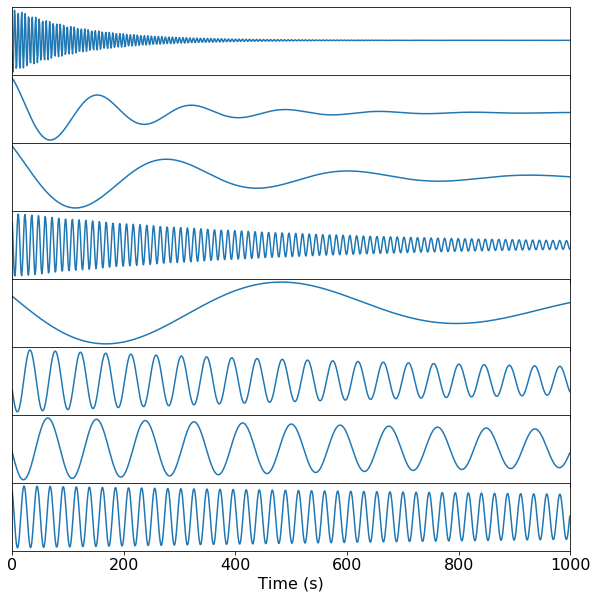

In [4]:
# Plot the oscillatory modes
fig, axs = plt.subplots(N // 2, sharex=True, figsize=(10, 10))
plt.subplots_adjust(hspace=0)

T = 1000
ts = np.arange(T)
for λi, δi, ax in zip(λ, δ, axs):
    
    xs = λi**ts * np.exp(1j*δi)
    
    ax.plot(ts, xs)
    ax.set_yticks([])

plt.xlim(0, T)
plt.xlabel('Time (s)')
plt.show()    

In [5]:
# Construct A matrix

# Build blocks for real modal form
blocks = []
for λi in λ:
    block = np.array([[ λi.real, λi.imag],
                      [-λi.imag, λi.real]])
    
    blocks.append(block)
    
Λ = sp.linalg.block_diag(*blocks)

In [6]:
# - randomly rotate to get a non-modal matrix
Q = ortho_group.rvs(dim=N)

A = Q.T @ Λ @ Q

In [7]:
# Build Linear Dynamic System matrix
C = np.random.rand(2, A.shape[0])

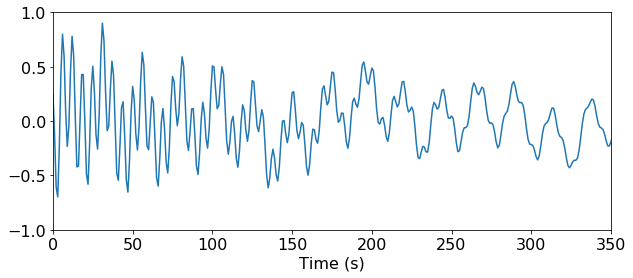

In [31]:
# Give the system a kick and see what happens - the initial state will be an arbitrary displacement from x = 0
x = np.zeros(N)
x[4] = 1

ys = np.empty((len(ts), 2))
for t in ts:
    x = A @ x
    ys[t, :] = C @ x


plt.figure(figsize=(10, 4))
plt.plot(ts, ys[:, 0])
plt.xlim(0, 350)
plt.ylim(-1, 1)
plt.xlabel('Time (s)')
# plt.legend(['$y_1$', '$y_2$'])

plt.show()

In [9]:
B = np.random.randn(N, 2)

In [10]:
# Naive control
y_des = np.array([.2, -.2]).reshape(-1, 1)

I = np.eye(N)
A_inv = np.linalg.inv(I - A)

u_static = np.linalg.inv(C @ A_inv @ B) @ y_des
x_static = A_inv @ B @ u_static

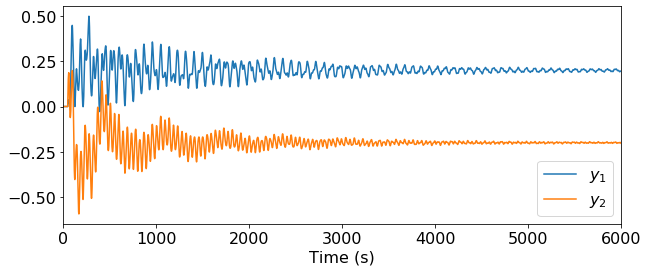

In [16]:
x = np.zeros(N).reshape(-1, 1)
ys = []

T = 6000
for t in np.arange(T):
    u = u_static if t > 50 else np.zeros(2).reshape(-1, 1)
    x = A @ x + B @ u
    ys.append(C @ x)
    
ys = np.array(ys)

plt.figure(figsize=(10, 4))
plt.plot(ys[:, :, 0])
plt.xlim(0, T)
plt.xlabel('Time (s)')
plt.legend(['$y_1$', '$y_2$'])

plt.show()

In [17]:
T = 1000  # Total simulation time
To = 800  # Time to reach target

blocks = [np.linalg.matrix_power(A, t) @ B for t in range(To-2, -1, -1)]
P = np.hstack(blocks)

temp = np.linalg.pinv(P) @ x_static
u_opt = np.repeat(u_static, T, axis=1)
u_opt[0, :To-1] = temp[::2].reshape(1, -1)
u_opt[1, :To-1] = temp[1::2].reshape(1, -1)

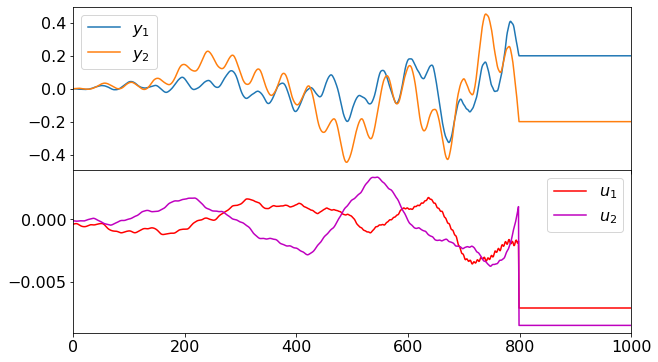

In [21]:
x = np.zeros(N).reshape(-1, 1)
ys = [C @ x]

for t in np.arange(T):
    u = u_opt[:, t].reshape(-1, 1)
    
    x = A @ x + B @ u
    ys.append(C @ x)
    
ys = np.array(ys)

fig, (y_ax, u_ax) = plt.subplots(2, sharex=True, figsize=(10, 6))
plt.subplots_adjust(hspace=0)

plt.sca(y_ax)
plt.plot(ys[:, :, 0])
plt.legend(['$y_1$', '$y_2$'])

plt.sca(u_ax)
plt.plot(u_opt[0, :].T, color='r')
plt.plot(u_opt[1, :].T, color='m')
plt.legend(['$u_1$', '$u_2$'])

plt.xlim(0, T)
plt.show()